In [1]:
"""
=======================================================================================
# This code runs with model.py, and process Video_16_3_2.mp4 with GT+Pred bounding box;
# Originally adapted in March, modified in Sep.
- Draw boxes
- Model deplyment
- Video Generation
LOG: Sep. 26th we're testing the baseline with EAST model, test it on ICDAR 2013
     Oct. 6th run script on remote cluster 
     Oct. 22th Visualization for feature layer before and after Conv-GRU
=======================================================================================
"""
import cv2
import os
import time
import datetime
import numpy as np
import uuid
import json
import functools
import logging
import collections
import argparse
import tensorflow as tf
# my own modules
import _init_paths
import matplotlib
matplotlib.use('Agg')
from utils.icdar import restore_rectangle
import lanms
from utils.eval import resize_image, sort_poly, detect
from utils.icdar import load_annotations_solo, check_and_validate_polys
from utils.nms_highlevel import intersection
from lstm.rnn_gru_test import ArrayModel
from config.configrnn import get_config

import matplotlib.pyplot as plt

logger = logging.getLogger(__name__)
logger.setLevel(logging.INFO)

############ Macros ############
BASIC = "basic"
CUDNN = "cudnn"
BLOCK = "block"
CONV  = "conv2d"
CUDNN_INPUT_LINEAR_MODE = "linear_input"
CUDNN_RNN_BIDIRECTION   = "bidirection"
CUDNN_RNN_UNIDIRECTION = "unidirection"
#
flags = tf.flags
flags.DEFINE_string("system", "local", "deciding running env")
flags.DEFINE_boolean('restore', True, 'whether to resotre from checkpoint')
flags.DEFINE_boolean('partially_restore', False, 'whether to restore the weights of back-bone')
flags.DEFINE_string("model", "test", "A type of model. Possible options are: small, medium, large.")
flags.DEFINE_integer("num_gpus", 1, "Larger than 1 will create multiple training replicas")
flags.DEFINE_string("rnn_mode", CONV, "one of CUDNN: BASIC, BLOCK")
flags.DEFINE_boolean('vis', False, "whether we would use plt")
flags.DEFINE_integer('running_count', 0, "know how many times we have run the model")

FLAGS = flags.FLAGS

/home/lxiaol9/anaconda3/envs/tensorflow/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
# used for iou searching and selecting TP, FP, FN #
def eval_single_frame(target, box):
    """
    input params:
        target, python ordered dict
        box, sorted boxes dict from predictions
    """
    TP   = 0
    FP   = 0
    FN   = 0
    precision = 0
    recall = 0
    F_measure = 0
    if not len(box['text_lines']) == 0:
        for t in target:
            d = np.array(t, dtype='int32')
            is_best = 0
            for m in box['text_lines']:
                n = np.array([m['x0'], m['y0'], m['x1'], m['y1'], m['x2'],
                              m['y2'], m['x3'], m['y3']], dtype='int32')

                # pick out the best match
                iou = intersection(n, d)
                if iou>is_best:
                    is_best = iou
            if is_best > 0.5:
                TP = TP+1
            elif is_best == 0:
                FN = FN +1
            else:
                FP = FP+1
        if TP > 0:
            precision = TP/(TP+FP)
            recall    = TP/(TP+FN)
            F_measure = 2*precision*recall/(precision+recall)
    return precision, recall, F_measure


def draw_illu(illu, rst):
    for t in rst['text_lines']:
        d = np.array([t['x0'], t['y0'], t['x1'], t['y1'], t['x2'],
                      t['y2'], t['x3'], t['y3']], dtype='int32')
        d = d.reshape(-1, 2)
        cv2.polylines(illu, [d], isClosed=True, thickness=2, color=(0, 0, 0))
    return illu


def draw_illu_gt(illu, rst, p, r, f):
    font = cv2.FONT_HERSHEY_SIMPLEX
    fontScale = 0.3
    fontColor = (255, 255, 255)
    lineType = 1
    infos = 'Precision ' + str(p)+ ', recall ' + str(r) + ', F_measure ' + str(f)
    cv2.putText(illu, infos,
                (2, 20),
                font,
                0.5,
                (255, 0, 0),
                lineType)
    for t in rst:
        d1 = t.reshape(-1, 2).astype(np.int32)
        cv2.polylines(illu, [d1], isClosed=True, thickness=2, color=(255, 0, 0))
        # bottomLeftCornerOfText = (int(t['x0']), int(t['y0']))

    return illu

In [3]:
video_set = []
test_data_path = '/work/cascades/lxiaol9/ARC/EAST/data/ICDAR2013/test/'
for root, dirs, files in os.walk(test_data_path):
    for file in files:
        if file.endswith('.mp4'):
            video_set.append(os.path.splitext(file)[0])
print(video_set)

['Video_39_2_3', 'Video_48_6_4', 'Video_5_3_2', 'Video_17_3_1', 'Video_35_2_3', 'Video_6_3_2', 'Video_11_4_1', 'Video_20_5_1', 'Video_49_6_4', 'Video_23_5_2', 'Video_44_6_4', 'Video_32_2_3', 'Video_53_7_4', 'Video_24_5_2', 'Video_1_1_2']


resnet_v1_50/block1 (?, ?, ?, 256)
resnet_v1_50/block2 (?, ?, ?, 512)
resnet_v1_50/block3 (?, ?, ?, 1024)
resnet_v1_50/block4 (?, ?, ?, 2048)
Shape of f_0 (?, ?, ?, 2048)
Shape of f_1 (?, ?, ?, 512)
Shape of f_2 (?, ?, ?, 256)
Shape of f_3 (?, ?, ?, 64)
Shape of h_0 (?, ?, ?, 2048), g_0 (?, ?, ?, 2048)
Shape of h_1 (?, ?, ?, 128), g_1 (?, ?, ?, 128)
Shape of h_2 (?, ?, ?, 64), g_2 (?, ?, ?, 64)
Shape of h_3 (?, ?, ?, 32), g_3 (?, ?, ?, 32)
resnet_v1_50/block1 (?, ?, ?, 256)
resnet_v1_50/block2 (?, ?, ?, 512)
resnet_v1_50/block3 (?, ?, ?, 1024)
resnet_v1_50/block4 (?, ?, ?, 2048)
Shape of f_0 (?, ?, ?, 2048)
Shape of f_1 (?, ?, ?, 512)
Shape of f_2 (?, ?, ?, 256)
Shape of f_3 (?, ?, ?, 64)
Shape of h_0 (?, ?, ?, 2048), g_0 (?, ?, ?, 2048)
Shape of h_1 (?, ?, ?, 128), g_1 (?, ?, ?, 128)
Shape of h_2 (?, ?, ?, 64), g_2 (?, ?, ?, 64)
Shape of h_3 (?, ?, ?, 32), g_3 (?, ?, ?, 32)
resnet_v1_50/block1 (?, ?, ?, 256)
resnet_v1_50/block2 (?, ?, ?, 512)
resnet_v1_50/block3 (?, ?, ?, 1024)
resnet

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


252 text boxes before nms, 4 text boxes after nms
> <ipython-input-4-cf41872c3e1a>(169)main()
-> plt.imshow((np.squeeze(feature_norm)*255).astype(np.uint8))
(Pdb) feature_norm.shape
(1, 128, 128)
(Pdb) plt.imshow((np.squeeze(feature_norm)*255).astype(np.uint8))
(Pdb) n
> <ipython-input-4-cf41872c3e1a>(170)main()
-> plt.title('Feature before CONV-GRU')
(Pdb) n
> <ipython-input-4-cf41872c3e1a>(171)main()
-> fig1.add_subplot(2, 2, 3)
(Pdb) n
> <ipython-input-4-cf41872c3e1a>(172)main()
-> plt.imshow((np.squeeze(state_norm)*255).astype(np.uint8))
(Pdb) state_norm.shape
(1, 1, 128, 128)
(Pdb) state_norm
array([[[[3.9070728, 4.254903 , 4.2326593, ..., 4.1452823, 3.8140497,
          2.871295 ],
         [4.549702 , 5.4288206, 5.545015 , ..., 4.8836074, 4.5620146,
          3.2132714],
         [4.581186 , 5.7401066, 5.9700904, ..., 5.005951 , 4.7157397,
          3.357885 ],
         ...,
         [4.497854 , 5.3331428, 5.372271 , ..., 5.744877 , 5.088589 ,
          3.2066884],
         [4.2

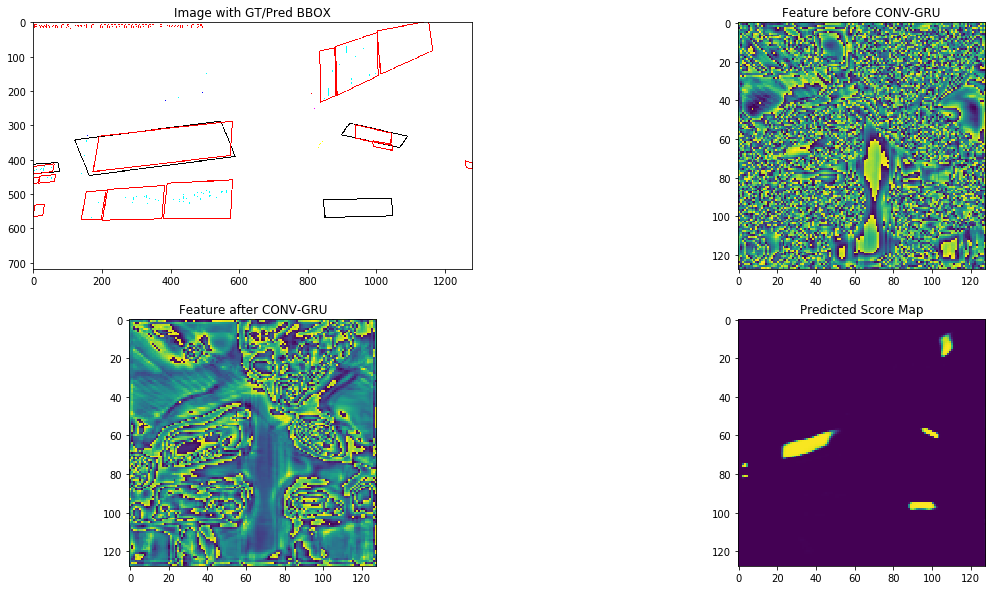

> <ipython-input-4-cf41872c3e1a>(180)main()
-> fig1.savefig(save_path+"frame" + str(i*config.num_steps+j) + ".png", dpi=500)
(Pdb) c


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


285 text boxes before nms, 3 text boxes after nms
> <ipython-input-4-cf41872c3e1a>(168)main()
-> import pdb; pdb.set_trace()
(Pdb) c
> <ipython-input-4-cf41872c3e1a>(179)main()
-> plt.show()
(Pdb) c


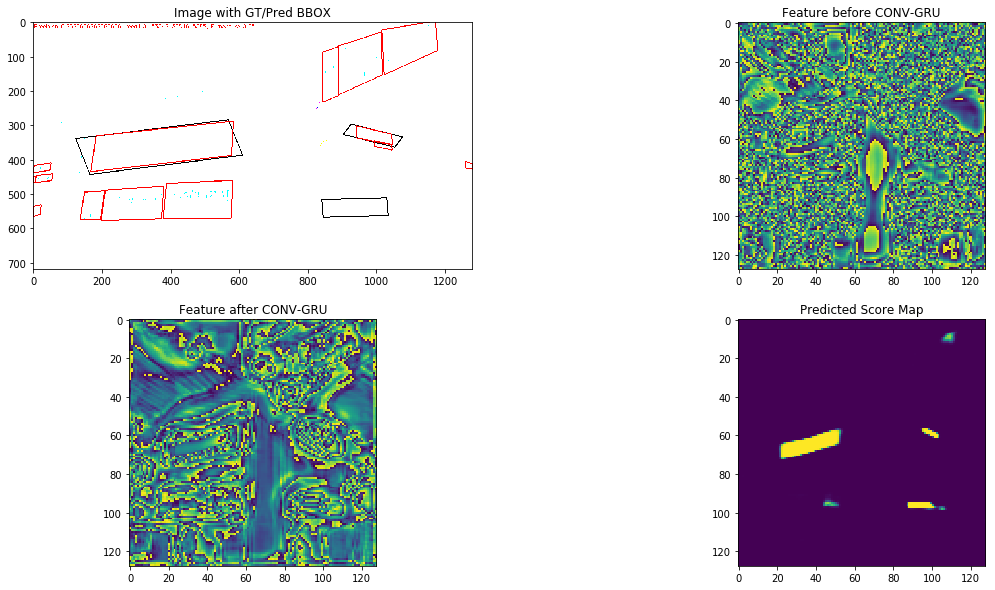

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


395 text boxes before nms, 5 text boxes after nms
> <ipython-input-4-cf41872c3e1a>(168)main()
-> import pdb; pdb.set_trace()
(Pdb) c
> <ipython-input-4-cf41872c3e1a>(179)main()
-> plt.show()
(Pdb) c


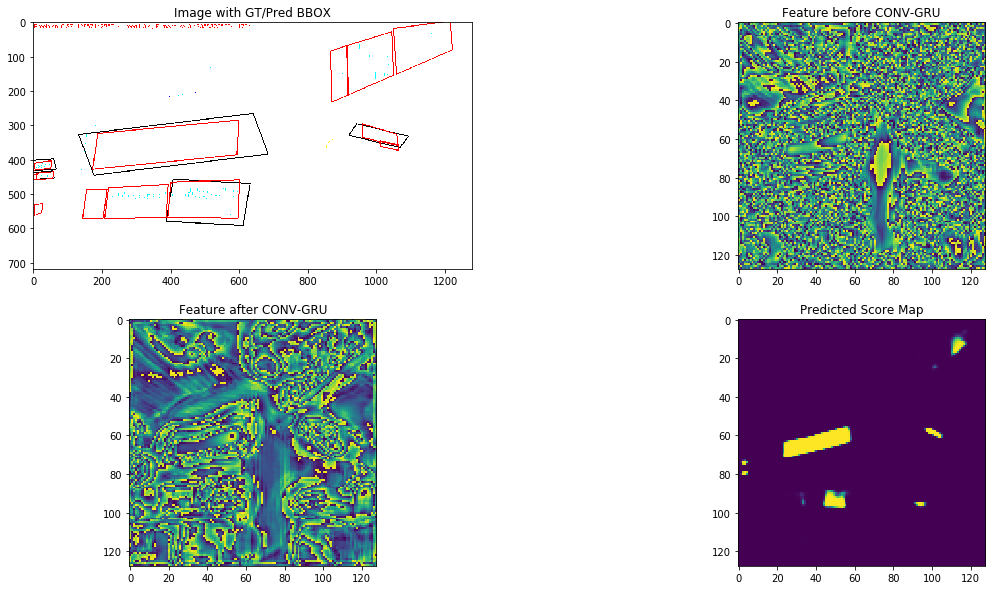

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


454 text boxes before nms, 5 text boxes after nms
> <ipython-input-4-cf41872c3e1a>(168)main()
-> import pdb; pdb.set_trace()
(Pdb) c
> <ipython-input-4-cf41872c3e1a>(179)main()
-> plt.show()
(Pdb) c


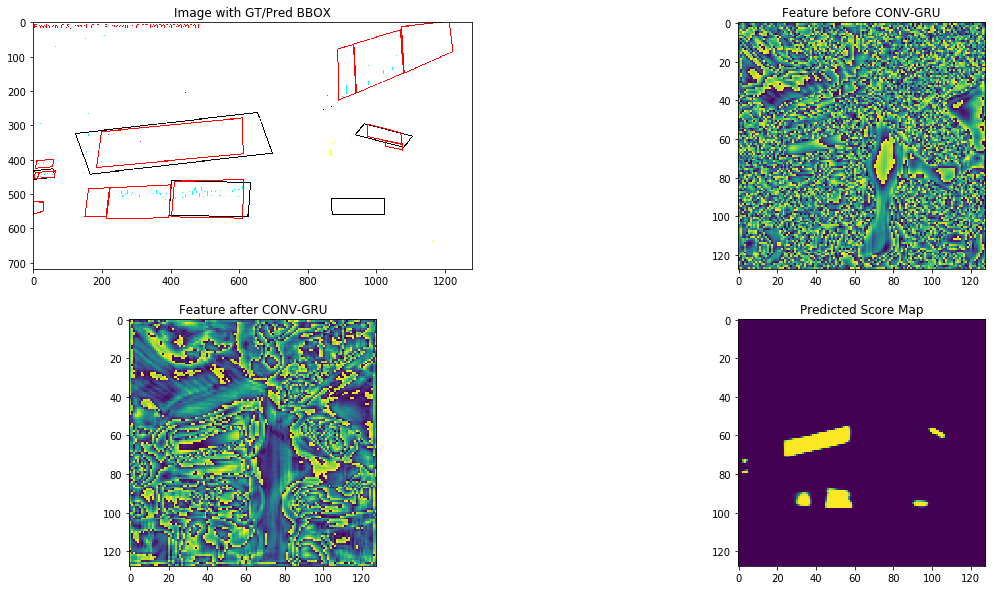

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


449 text boxes before nms, 4 text boxes after nms
> <ipython-input-4-cf41872c3e1a>(168)main()
-> import pdb; pdb.set_trace()
(Pdb) c
> <ipython-input-4-cf41872c3e1a>(179)main()
-> plt.show()
(Pdb) c


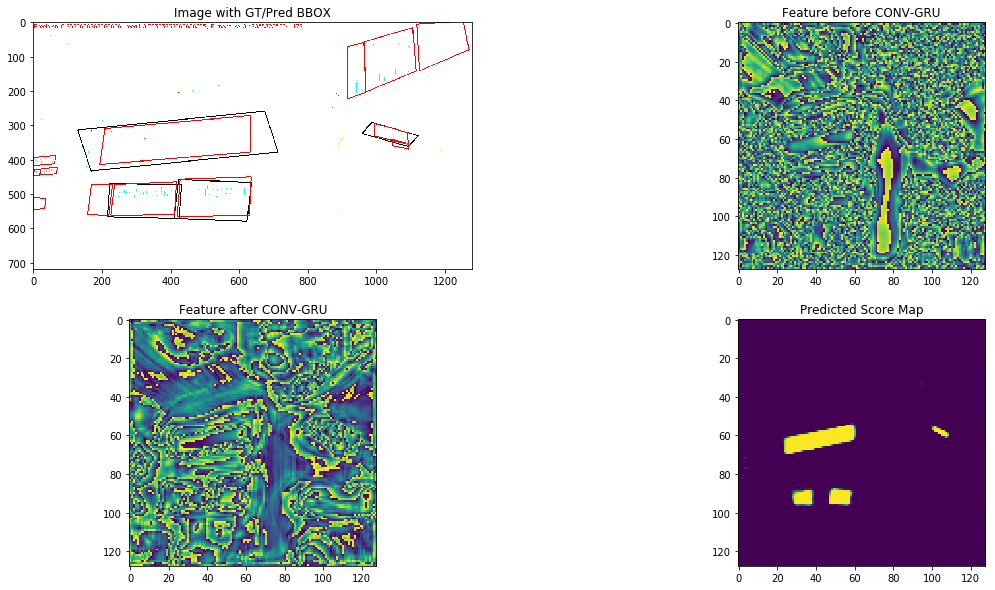

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


449 text boxes before nms, 6 text boxes after nms
> <ipython-input-4-cf41872c3e1a>(168)main()
-> import pdb; pdb.set_trace()
(Pdb) c
> <ipython-input-4-cf41872c3e1a>(179)main()
-> plt.show()
(Pdb) c


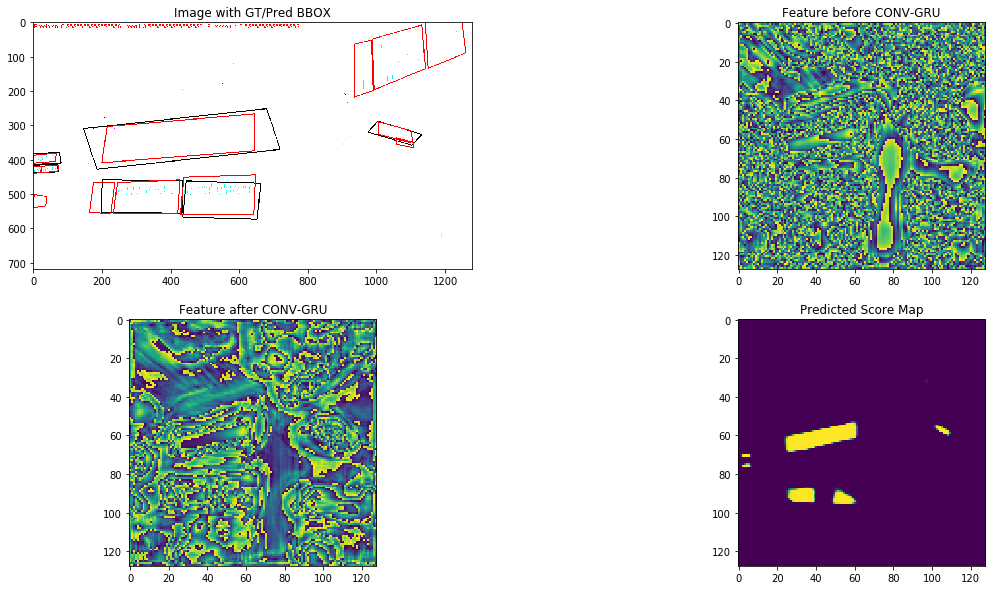

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


467 text boxes before nms, 5 text boxes after nms
> <ipython-input-4-cf41872c3e1a>(168)main()
-> import pdb; pdb.set_trace()
(Pdb) c
> <ipython-input-4-cf41872c3e1a>(179)main()
-> plt.show()
(Pdb) c


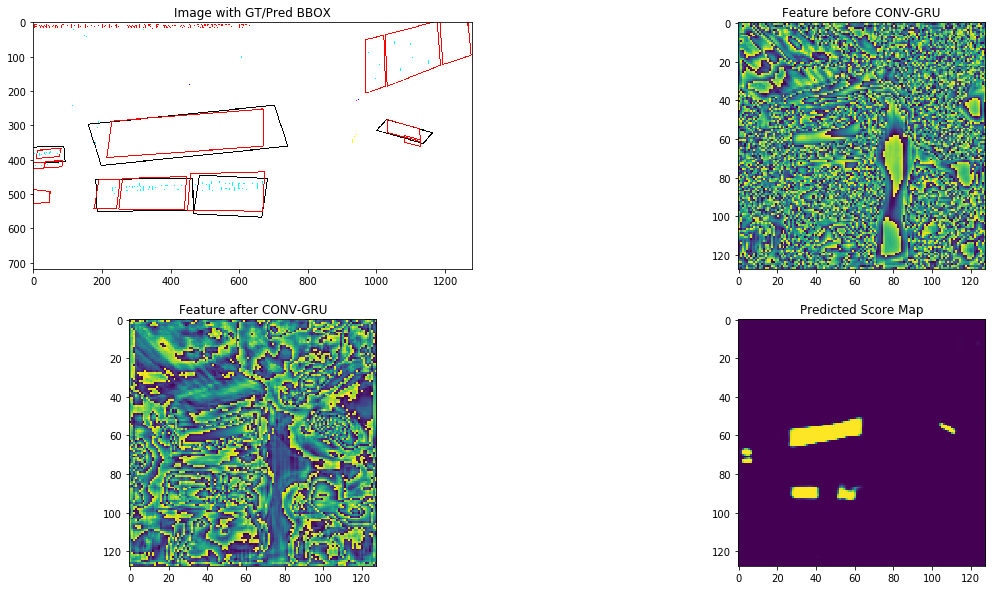

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


538 text boxes before nms, 7 text boxes after nms
> <ipython-input-4-cf41872c3e1a>(168)main()
-> import pdb; pdb.set_trace()
(Pdb) c
> <ipython-input-4-cf41872c3e1a>(179)main()
-> plt.show()
(Pdb) c


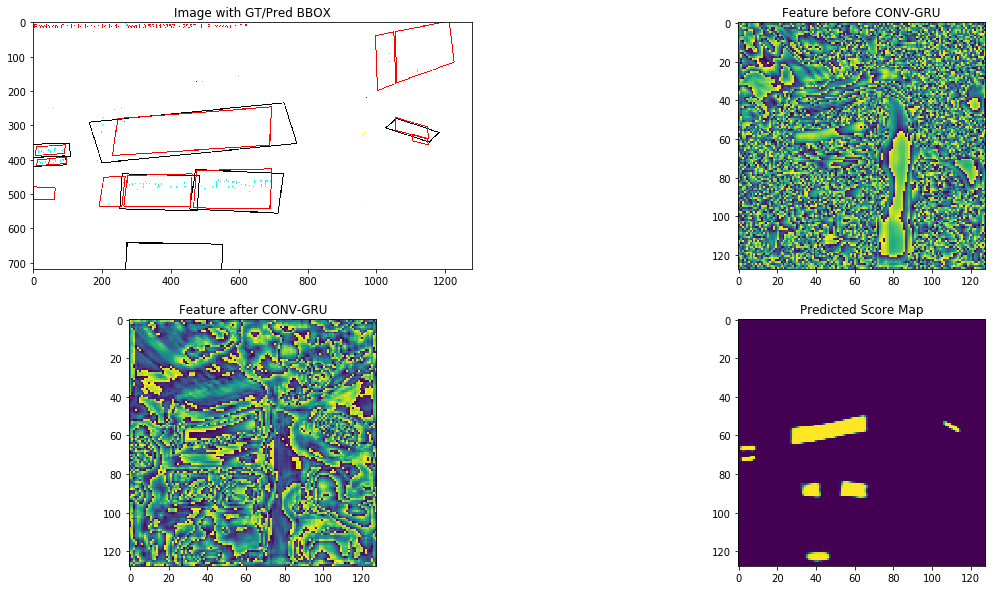

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


596 text boxes before nms, 8 text boxes after nms
> <ipython-input-4-cf41872c3e1a>(168)main()
-> import pdb; pdb.set_trace()
(Pdb) c
> <ipython-input-4-cf41872c3e1a>(179)main()
-> plt.show()
(Pdb) c


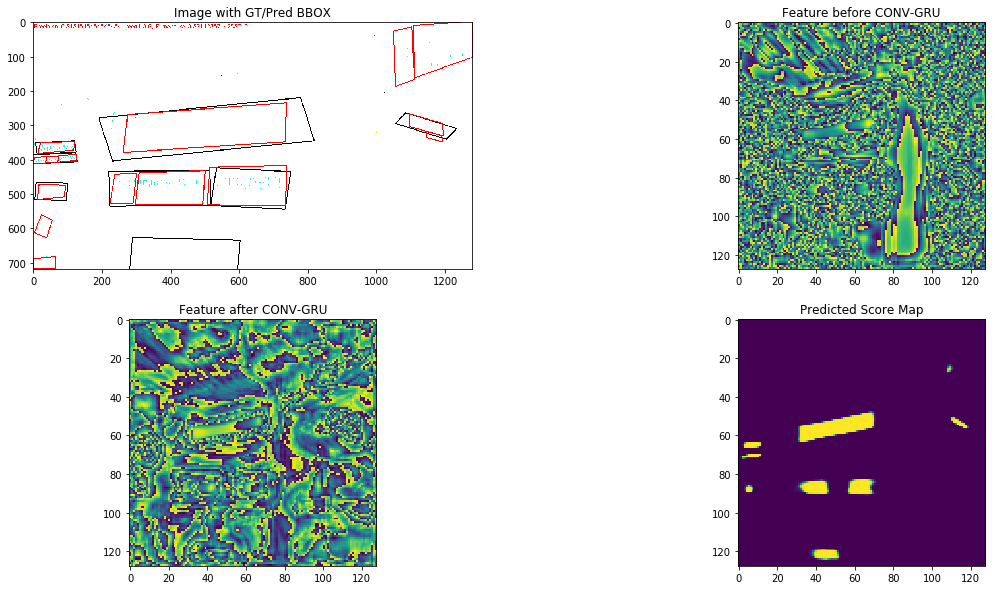

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


569 text boxes before nms, 6 text boxes after nms
> <ipython-input-4-cf41872c3e1a>(168)main()
-> import pdb; pdb.set_trace()
(Pdb) c
> <ipython-input-4-cf41872c3e1a>(179)main()
-> plt.show()
(Pdb) c


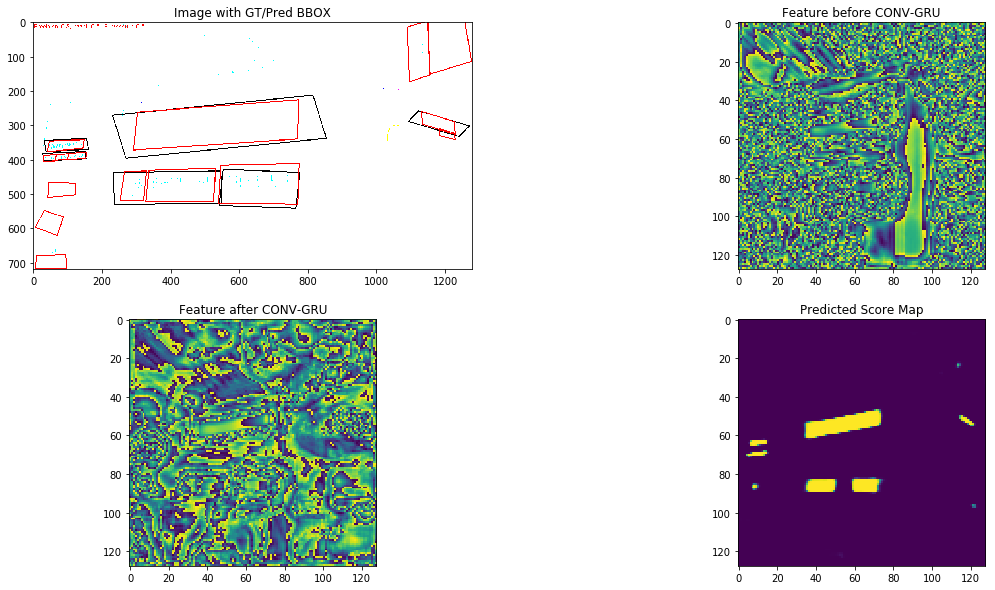

testing results are P:0.016347457256548167, R:0.012457979730707005, F1:0.013374996463231757 on Video_35_2_3
here is the precision
0.5394661
here is the recall
0.41111332
here is the f-score
0.44137487
['Video_39_2_3', 'Video_48_6_4', 'Video_5_3_2', 'Video_17_3_1', 'Video_35_2_3', 'Video_6_3_2', 'Video_11_4_1', 'Video_20_5_1', 'Video_49_6_4', 'Video_23_5_2', 'Video_44_6_4', 'Video_32_2_3', 'Video_53_7_4', 'Video_24_5_2', 'Video_1_1_2']


In [4]:
%matplotlib inline
FLAGS.vis = True
def main():
    checkpoint_path = '/work/cascades/lxiaol9/ARC/EAST/checkpoints/GRU_east/'
    idname1 = '20181021-153144'
    idname2 = '-10003'
    test_data_path = '/work/cascades/lxiaol9/ARC/EAST/data/ICDAR2013/test/'
    save_path = '/work/cascades/lxiaol9/ARC/EAST/data/ICDAR2013/test_results_gru/'
   
    idx = 0  # initial frame number
    index = [4] # video 35_2_3
#     index = range(1, len(video_set))
    config = get_config(FLAGS)
    config.batch_size = 1
    config.num_layers = 1
    config.num_steps  = 10
    #>>>>>>>>>>>>>>>>>>>>>>Sort test video>>>>>>>>>>>>>>>>>>>>>>>>>>>#
#     index = range(0, 1)
    if not os.path.exists(checkpoint_path):
        raise RuntimeError(
            'Checkpoint `{}` not found'.f10003ormat(checkpoint_path))
    if not os.path.exists(save_path):
        os.makedirs(save_path)  
    logger.info('loading model')
    #>>>>>>>>>>>>>>>>>>>>>>> Loading Model >>>>>>>>>>>>>>>>>>>>>>>>>#
    gpu_options = tf.GPUOptions(allow_growth=True)
    input_images = tf.placeholder(tf.float32, shape=[None, None, None, 3], name='input_images')
    if FLAGS.running_count == 0:
        reuse_variables=False
    else:
        reuse_variables=True
    with tf.name_scope("Val"):
        # use placeholder to stand for input and targets
        initializer = tf.random_normal_initializer()
        x_val = tf.placeholder(tf.float32, shape=[None, config.num_steps, None, None, 3])
        model = ArrayModel(False, config, x_val, reuse_variables=reuse_variables, initializer=initializer)
        FLAGS.running_count+=1
    var_total = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES)
    #>>>>>>>>>>>>>>>>>>>>>>>> restore the model from weights>>>>>>>>#
    soft_placement = False
    saver = tf.train.Saver()
    config_proto = tf.ConfigProto(allow_soft_placement = soft_placement)
    model_path = checkpoint_path + idname1 + '/' + idname2
    sess = tf.Session(config=tf.ConfigProto(allow_soft_placement=True))
    logger.info('Restore from {}'.format(model_path))
    saver.restore(sess, model_path)
    #>>>>>>>>>>>>>>>>>>>>>>Start evaluation>>>>>>>>>>>>>>>>>>>>>>>>>#
    P_test = []
    R_test = []
    f1_test = []
    for k in index:
        # for one video
        P_video = []
        R_video = []
        f1_video = []
        video_save = save_path + video_set[k] + idname1 + '_' + idname2 + '.avi'
        t_start = time.time()
        # sort up all the paths
        xml_solo_path = test_data_path + video_set[k]
        raw_video_path = test_data_path + video_set[k]+'.mp4'
        cap = cv2.VideoCapture(raw_video_path)
        frame_width = int(cap.get(3))
        frame_height = int(cap.get(4))
        cnt_frame = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        out = cv2.VideoWriter(video_save, cv2.VideoWriter_fourcc('M','J','P','G'), 10, (frame_width,frame_height))
        # 1. load both polys and tags; 2. generate geo maps(the format of polys and tags need to match)
        polys_array_list, tags_array_list, id_list_list, frame_num = load_annotations_solo(xml_solo_path, \
                    1, cnt_frame, frame_width, frame_height)
        #>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>loop over frames in the time steps >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
#         for i in range(int(cnt_frame/config.num_steps)):
        for i in range(7, 8):
            print("Processing %d batch from %s"%(i, video_set[k]))
            data_seq = np.zeros((1, config.num_steps, 512, 512, 3), dtype=np.float32)
            data_original = np.zeros((1, config.num_steps, frame_height, frame_width, 3), dtype=np.float32)
            for m in range(config.num_steps):
                cap.set(1, i*config.num_steps+m)
                ret, frame = cap.read()
                im_resized = cv2.resize(frame, (int(512), int(512)))
#                 im_resized = frame[0:512, 0:512, :]
                data_original[0, m, :, :,:] = frame
                data_seq[0, m, :, : , :] = im_resized
            #>>>>>>>>>>>>>>>>>>>>>>>>>Now it's time to run the model>>>>>>>>>>>>>>>>>>>>>>>>>>
            state = sess.run(model.initial_state)
            # tensors dict to run
            fetches = {
                    "score_map": model.score_map_set,
                    "geometry_map": model.geometry_set,
                    "state_norm": model.statenorm_set,
                    "feature_norm": model.featurenorm_set
                    }
            sum_kernel = np.zeros((11, 11, 32, 32), dtype=np.float32)
            for t in range(32):
                sum_kernel[:, :, t, t] = np.ones((11, 11), dtype=np.float32)
            feed_dict = {}
            feed_dict[model.input_data] = data_seq
            feed_dict[model.sum_kernel] = sum_kernel
            for n, h in enumerate(model.initial_state):
                feed_dict[h] = state[n]
            timer = collections.OrderedDict([
                ('net', 0),
                ('restore', 0),
                ('nms', 0)
            ])
            start = time.time()
            vals = sess.run(fetches, feed_dict=feed_dict)
            timer['net'] = time.time() - start
            #>>>>>>>>>>>>>>>>>>>>>>>>Okay!!!We could evalute the results now>>>>>>>>>>>>>>>>>>>
            for j in range(config.num_steps):
                rtparams = collections.OrderedDict()
                rtparams['start_time'] = datetime.datetime.now().isoformat()
                rtparams['image_size'] = '{}x{}'.format(frame_width, frame_height)
                # im_resized, (ratio_h, ratio_w) = resize_image(img)
                ratio_h, ratio_w = 512/frame_height, 512/frame_width
                rtparams['working_size'] = '{}x{}'.format(512, 512)
                # results refinement via NMS
                score = vals["score_map"][j]
                geometry = vals["geometry_map"][j]
                state_norm = vals["state_norm"][j]
                feature_norm = vals["feature_norm"][j]
                boxes, timer = detect(score_map=score, geo_map=geometry, timer=timer)
                logger.info('net {:.0f}ms, restore {:.0f}ms, nms {:.0f}ms'.format(
                    timer['net']*1000, timer['restore']*1000, timer['nms']*1000))
                if boxes is not None:
                    scores = boxes[:,8].reshape(-1)
                    boxes = boxes[:, :8].reshape((-1, 4, 2))
                    boxes[:, :, 0] /= ratio_w
                    boxes[:, :, 1] /= ratio_h

                duration = time.time() - start
                timer['overall'] = duration
                logger.info('[timing] {}'.format(duration))
                text_lines = []
                if boxes is not None:
                    text_lines = []
                    for box, score in zip(boxes, scores):
                        box = sort_poly(box.astype(np.int32))
                        if np.linalg.norm(box[0] - box[1]) < 5 or np.linalg.norm(box[3]-box[0]) < 5:
                            continue
                        tl = collections.OrderedDict(zip(
                            ['x0', 'y0', 'x1', 'y1', 'x2', 'y2', 'x3', 'y3'],
                            map(float, box.flatten())))
                        tl['score'] = float(score)
                        text_lines.append(tl)
                pred = {
                    'text_lines': text_lines,
                    'rtparams': rtparams,
                    'timing': timer,
                }
                text_polys, text_tags = polys_array_list[i*10+j], tags_array_list[i*10+j]
                text_polys, text_tags = check_and_validate_polys(text_polys, text_tags, (frame_height, frame_width))
                # out.write(new_img)
                #>>>>>>>>>>>>>>>>>>>>>>>>Evaluation>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
                targets = text_polys
                precision, recall, f1 = eval_single_frame(targets, pred)
                P_video.append(precision)
                R_video.append(recall)
                f1_video.append(f1)
                img = data_original[0, j, :, :,:]
                new_img = draw_illu(img.copy(), pred)
                new_img1 = draw_illu_gt(new_img.copy(), targets, precision, recall, f1)
                out.write(new_img)
                # using for pre-testing
                if FLAGS.vis:
                    fig1 = plt.figure(figsize=(20, 10))
                    fig1.add_subplot(2, 2, 1)
                    plt.imshow(new_img1)
                    plt.title("Image with GT/Pred BBOX")
                    fig1.add_subplot(2, 2, 2)
                    import pdb; pdb.set_trace()
                    plt.imshow((np.squeeze(feature_norm)*255).astype(np.uint8))
                    plt.title('Feature before CONV-GRU')
                    fig1.add_subplot(2, 2, 3)
                    plt.imshow((np.squeeze(state_norm)*255).astype(np.uint8))
                    plt.title('Feature after CONV-GRU') 
                    fig1.add_subplot(2, 2, 4)
#                     import pdb; pdb.set_trace()
                    plt.imshow((np.squeeze(vals["score_map"][j]*255)).astype(np.uint8))
                    plt.title('Predicted Score Map')
                    import pdb; pdb.set_trace()
                    plt.show()
                    fig1.savefig(save_path+"frame" + str(i*config.num_steps+j) + ".png", dpi=500)
                if cv2.waitKey(25) & 0xFF == ord('q'):
                    break
            # evaluation on ret and gt
        P_test.append(np.array(P_video, dtype=np.float32))
        R_test.append(np.array(R_video, dtype=np.float32))
        f1_test.append(np.array(f1_video, dtype=np.float32))
#         print(P_video)
#         print(R_video)
#         print(f1_video)
        total_num = int(cnt_frame/config.num_steps)*config.num_steps
        print("testing results are P:{}, R:{}, F1:{} on ".format(sum(P_video)/total_num, sum(R_video)/total_num, sum(f1_video)/total_num)+video_set[k])
        cap.release()
        out.release()                # results refinement via NMS
    print('here is the precision')
    for item in P_test:
        print(np.mean(item))
    print('here is the recall')
    for item in R_test:
        print(np.mean(item))
    print('here is the f-score')
    for item in f1_test:
        print(np.mean(item))
    print(video_set)
if __name__ == '__main__':
    main()

In [ ]:
n
